In [1]:
%matplotlib inline

# data manipulation
import pandas as pd
import numpy as np
from operator import itemgetter


## learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

## preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


### model performance
from sklearn import metrics

#ploting modules
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

## Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from IPython.display import Image

### Load and split data

In [2]:
datapath = '../data/clinvarHC_modeling.csv.gz'
SEED = 2718281
data = pd.read_csv(datapath,sep = ',',index_col='ChrPosRefAlt')
X,y = data.drop(['clinSigSimple'],axis = 1), data[['clinSigSimple']]

## train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=SEED,stratify = y)


### Preprocessing

In [3]:
categorical_feature_mask = X_train.dtypes==object       # esto nos da un vector booleano 
categorical_columns = X_train.columns[categorical_feature_mask].tolist()  # acá picnhamos los nombres de esas columnas
numerical_columns = X_train.columns[~X_train.columns.isin(categorical_columns)] # defino las numéricas como el complemento de las categóricas 


numerical_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))])  # Esto es una vacancia de Sklearn, no permite aún "centrar" matrizes sparse


categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])      

preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer,numerical_columns),
    ('cat', categorical_transformer,categorical_columns)
])


### Qué quiero ver: 

* Optimización de hyperparámetros : gridsearch

* Convencernos que L1 mata features correlacionados y L2 distribuye los pesos

* Recursive feature elimination

* Utilizando L1 (que tiende a matar features correlacionados): sparsity 

* Nro features (y cuáles) en términos de C. 




## Model

In [ ]:
### Construimos el Pipeline
## Regresion Logistica 
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(solver = 'liblinear'))])  
#especificamos el solver para evitar warnings


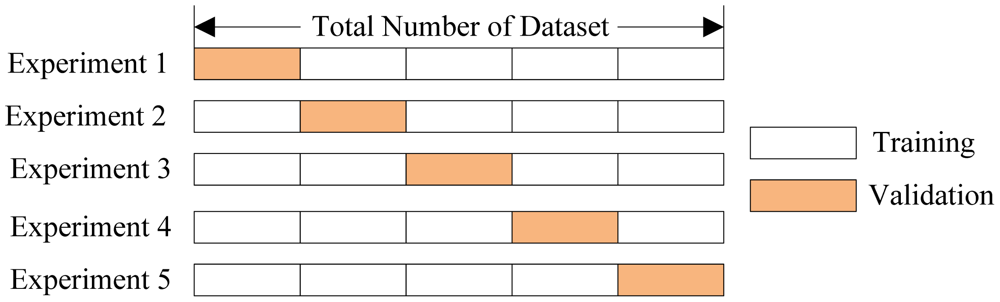

In [12]:
Image(filename = "./CrossValid.png", width=600, height=600)

In [5]:
#lr_C =  [0.1,1,10]
lr_C =  [0.0001,0.001,0.01,0.1,1,10,100,1000]

param_grid = [
  {'clasificador__C':lr_C, 'clasificador__penalty': ['l1']}
 ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=2,return_train_score = True,
                     scoring = 'roc_auc').fit(X_train, y_train.ClinvarHC.ravel())

############
# y si usamos average_precision?
#search = GridSearchCV(pipeline, param_grid, 
#                      cv=2,return_train_score = True,
#                     scoring = 'average_precision').fit(X_train, y_train.ClinvarHC.ravel())

* GridSearchCV No retiene explícitamente los modelos generados (i.e. , sus coeficientes) en cada combinación de parámetros de la grilla de búsqueda. 



* Sólo retiene los scores de cada modelo generado, y los parámetros del modelo de "mejor performance" acorde al criterio por default (maximizar el score medio en el evaluation set)



### Cómo le va en performance?

Text(0.5, 0, 'regularization parameter')

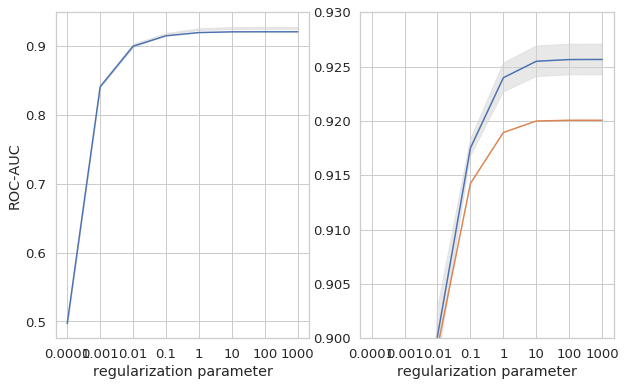

In [12]:
matplotlib.rcParams['figure.figsize'] = [10, 6]
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2)


results = search.cv_results_
cc = ['mean_train_score','std_train_score','mean_test_score']
performance = pd.DataFrame(itemgetter(*cc)(results),index = cc,columns = lr_C).transpose()

performance['C'] = [str(c) for c in lr_C]
#ax = sns.pointplot(x="C", y="mean_train_score",
#                  data=performance)

#var = abs(performance.mean_train_score-performance.mean_test_score)
perf_train = performance.mean_train_score
perf_test = performance.mean_test_score

ax1.plot(performance.C, performance.mean_test_score)

ylow =   perf_train - performance.std_train_score
yup = perf_train + performance.std_train_score

ax1.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax1.set_ylabel('ROC-AUC')
ax1.set_xlabel('regularization parameter')


ax2.plot(performance.C, performance.mean_train_score)
ax2.plot(performance.C, performance.mean_test_score)

#ylow = 1-performance.mean_train_score - performance.std_train_score
#yup = performance.mean_train_score + performance.std_train_score

ax2.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
ax2.set_ylim([0.9,0.93])

ax2.set_xlabel('regularization parameter')



In [15]:
numerical_names = pipeline.named_steps['preprocessing'].transformers_[0][2].tolist()
categorical_output_names = pipeline.named_steps['preprocessing'].named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()

cols = numerical_names + categorical_output_names  # ver nota abajo

search.best_estimator_['clasificador']

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### C= 1000?? Es necesario? Qué implicancia tiene en el modelo?

### Fijensé que para valores de C ariba de 0.1, ya el modelo empieza a sobreajustar.
* No obstante, hasta C =1 parece tener sentido y e

### Entreno modelos para cada valor de C (sin CV, usando todo el train):

* Esto nos va a permitir analizar los coeficientes de cada modelo, en particular cuán sparso es.

In [35]:
sparsity_l1_LR = {}
model = {}
for c in lr_C:
    print(c)
    pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(C=c,solver = 'liblinear',penalty='l1'))])
    Id = '%s'%c
    res = pipeline.fit(X_train,y_train.ClinvarHC.ravel())
    model.update({Id:res})

    sparc = np.mean(model[Id]['clasificador'].coef_ == 0) * 100
    sparsity_l1_LR.update({Id: sparc})

sparsity = pd.Series(sparsity_l1_LR)

0.0001
0.001
0.01
0.1
1
10
100
1000


Notar que a menor penalización, más tarda en converger. 

Text(0, 0.5, 'regularization parameter')

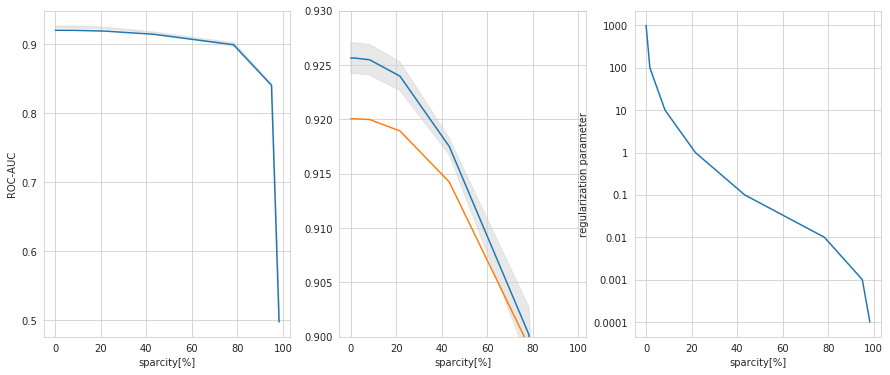

In [9]:
matplotlib.rcParams['figure.figsize'] = [15, 6]
sns.set_style("whitegrid")
fig, (ax1, ax2,ax3) = plt.subplots(1,3)


results = search.cv_results_
cc = ['mean_train_score','std_train_score','mean_test_score']
performance = pd.DataFrame(itemgetter(*cc)(results),index = cc,columns = lr_C).transpose()

performance['C'] = [str(c) for c in lr_C]
#ax = sns.pointplot(x="C", y="mean_train_score",
#                  data=performance)

#var = abs(performance.mean_train_score-performance.mean_test_score)
perf_train = performance.mean_train_score
perf_test = performance.mean_test_score

ax1.plot(sparsity, performance.mean_test_score)

ylow =   perf_train - performance.std_train_score
yup = perf_train + performance.std_train_score

ax1.fill_between(sparsity, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax1.set_ylabel('ROC-AUC')
ax1.set_xlabel('sparcity[%]')


ax2.plot(sparsity, performance.mean_train_score)
ax2.plot(sparsity, performance.mean_test_score)

#ylow = 1-performance.mean_train_score - performance.std_train_score
#yup = performance.mean_train_score + performance.std_train_score

ax2.fill_between(sparsity, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
ax2.set_ylim([0.9,0.93])
ax2.set_xlabel('sparcity[%]')

ax3.plot(sparsity,performance.C)
ax3.set_xlabel('sparcity[%]')
ax3.set_ylabel('regularization parameter')




### A mayor penalización modelo más simple
* mayor penalización, (menor C), el modelo penaliza más coeficientes (los lleva a cero)
* Vemos que con un 80% de sparsity, osea sólo con el 20% de los features al modelo le va muy bien AUC ~ 0.9 y además, la generalización es buena (el evaluation cae dentro del intervalo del training) 

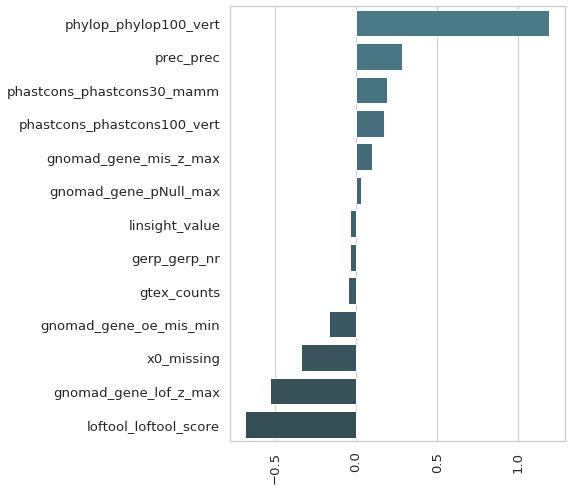

In [17]:
matplotlib.rcParams['figure.figsize'] = [6,8]
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
coefs = pd.Series(model['0.01']['clasificador'].coef_[0])

coefs.index = cols
coefs = coefs.sort_values(ascending=False)

# filtro los features que no fueron eliminados por L1
ii = abs(coefs)>0
g = sns.barplot(coefs[ii],coefs.index[ii], palette =sns.diverging_palette(220, 20, n=50, center = "dark"))
plt.xticks(rotation=90)
plt.show()

# Cuál es la performance del modelo?

In [37]:
ypred_test = model['1'].predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test,ypred_test)

0.9244570385825382

### Que pasa si usamos L2?
* Sparsity? 
* Performance?
* Redundancia? Robutez?

In [18]:

pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(solver = 'liblinear'))])  

lr_C =  [0.0001,0.001,0.01,0.1,1,10,100,1000]
param_grid = [ {'clasificador__C':lr_C, 'clasificador__penalty': ['l2']} ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=2,return_train_score = True,
                     scoring = 'roc_auc').fit(X_train, y_train.ClinvarHC.ravel())

##### Recompute models

sparsity_l2_LR = {}
model = {}
for c in lr_C:
    print(c)
    pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',LogisticRegression(C=c,solver = 'liblinear',penalty='l2'))])
    Id = '%s'%c
    res = pipeline.fit(X_train,y_train.ClinvarHC.ravel())
    model.update({Id:res})

    sparc = np.mean(model[Id]['clasificador'].coef_ == 0) * 100
    sparsity_l2_LR.update({Id: sparc})

    
sparsity = pd.Series(sparsity_l2_LR)

0.0001
0.001
0.01
0.1
1
10
100
1000


Text(0.5, 0, 'regularization parameter')

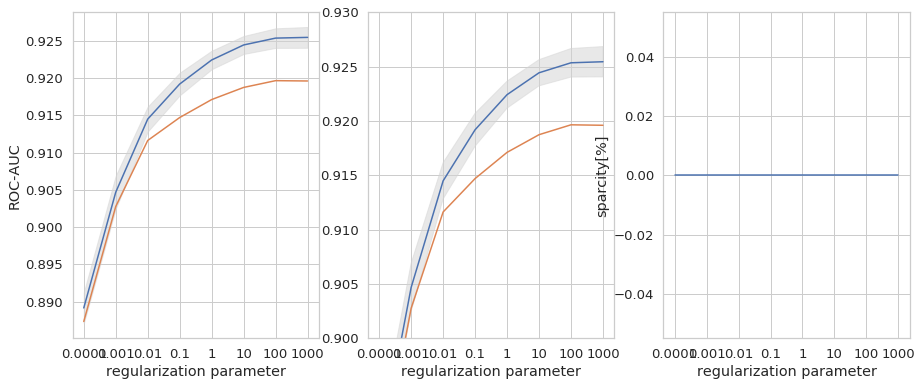

In [19]:

matplotlib.rcParams['figure.figsize'] = [15,6]
sns.set_style("whitegrid")
fig, (ax1, ax2,ax3) = plt.subplots(1,3)


results = search.cv_results_
cc = ['mean_train_score','std_train_score','mean_test_score']
performance = pd.DataFrame(itemgetter(*cc)(results),index = cc,columns = lr_C).transpose()

performance['C'] = [str(c) for c in lr_C]
#ax = sns.pointplot(x="C", y="mean_train_score",
#                  data=performance)

#var = abs(performance.mean_train_score-performance.mean_test_score)
perf_train = performance.mean_train_score
perf_test = performance.mean_test_score


ylow =   perf_train - performance.std_train_score
yup = perf_train + performance.std_train_score

ax1.plot(performance.C, performance.mean_train_score)
ax1.plot(performance.C, performance.mean_test_score)
ax1.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')

ax1.set_ylabel('ROC-AUC')
ax1.set_xlabel('regularization parameter')


ax2.plot(performance.C, performance.mean_train_score)
ax2.plot(performance.C, performance.mean_test_score)

#ylow = 1-performance.mean_train_score - performance.std_train_score
#yup = performance.mean_train_score + performance.std_train_score

ax2.fill_between(performance.C, ylow, yup,
    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
ax2.set_ylim([0.9,0.93])
ax2.set_xlabel('regularization parameter')

ax3.plot(performance.C,sparsity)
ax3.set_ylabel('sparcity[%]')
ax3.set_xlabel('regularization parameter')

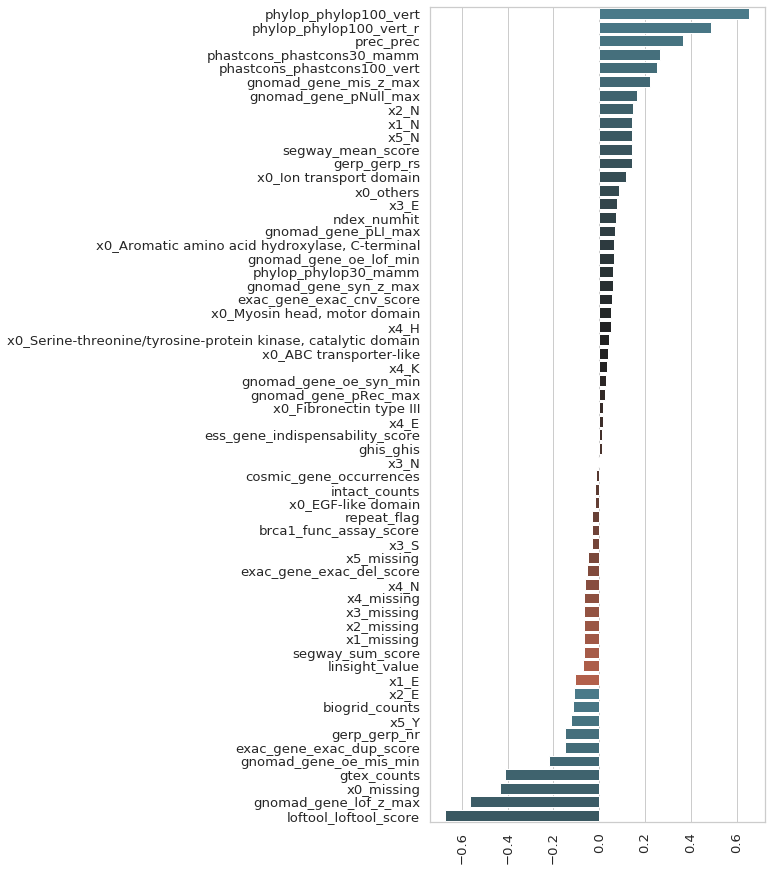

In [21]:
matplotlib.rcParams['figure.figsize'] = [6,15]
sns.set_style("whitegrid")
coefs = pd.Series(model['0.01']['clasificador'].coef_[0])

coefs.index = cols
coefs = coefs.sort_values(ascending=False)

# filtro los features que no fueron eliminados por L1
ii = abs(coefs)>0
g = sns.barplot(coefs[ii],coefs.index[ii], palette =sns.diverging_palette(220, 20, n=50, center = "dark"))
plt.xticks(rotation=90)
plt.show()

# Recursive Feature Elimination?

In [24]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV

# create pipeline
rfe = RFECV(estimator=LogisticRegression(penalty = 'l2'))
model = LogisticRegression(penalty = 'l2')
pipeline = Pipeline(steps=[('preprocessing',preprocessor),('rfe',rfe),('clasificador',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1234)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('AUC: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

AUC: 0.917 (0.004)


In [25]:
rfe = RFECV(estimator=LogisticRegression(penalty = 'l2',solver = 'liblinear',C = 0.001),cv = 2)
model = LogisticRegression(penalty = 'l2',solver = 'liblinear',C = 0.001)
pipeline = Pipeline(steps=[('preprocessing',preprocessor),('rfe',rfe),('clasificador',model)])

rfemodel = pipeline.fit(X_train,y_train.ClinvarHC.ravel())

In [29]:
print(rfemodel.named_steps['clasificador'])
metrics.roc_auc_score(y_train,rfemodel.predict_proba(X_train)[:,1])
#metrics.roc_auc_score(y_test,aver.predict_proba(X_test)[:,1])

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


0.907371516643236

### Que tenemos?
* a la cabeza, conservación con approache filogenético --variant fetaure--
* Expresión diferencial (gtex) --gene fetaure-- 
* Loss of function --gene fetaure--?
* gnomad, loss of funcion z-score  --gene fetaure--
* Intepro domain (falta de)  --Protein fetaure--
* Inferencia recesive gene
* gnomad max O/E missense per gene. 

##### En menor medida:



In [31]:
coeficientes = rfemodel.named_steps['clasificador'].coef_[0]

df = pd.DataFrame({'support' : rfemodel.named_steps['rfe'].support_,
'ranking' : rfemodel.named_steps['rfe'].ranking_ },index = cols) 

selected = df[df.support == True]

res = pd.concat([selected,pd.DataFrame(coeficientes,index = selected.index)],axis =1)
res['abs_coef'] = res[0].abs()
res.sort_values(by = 0,ascending = False,inplace = True)

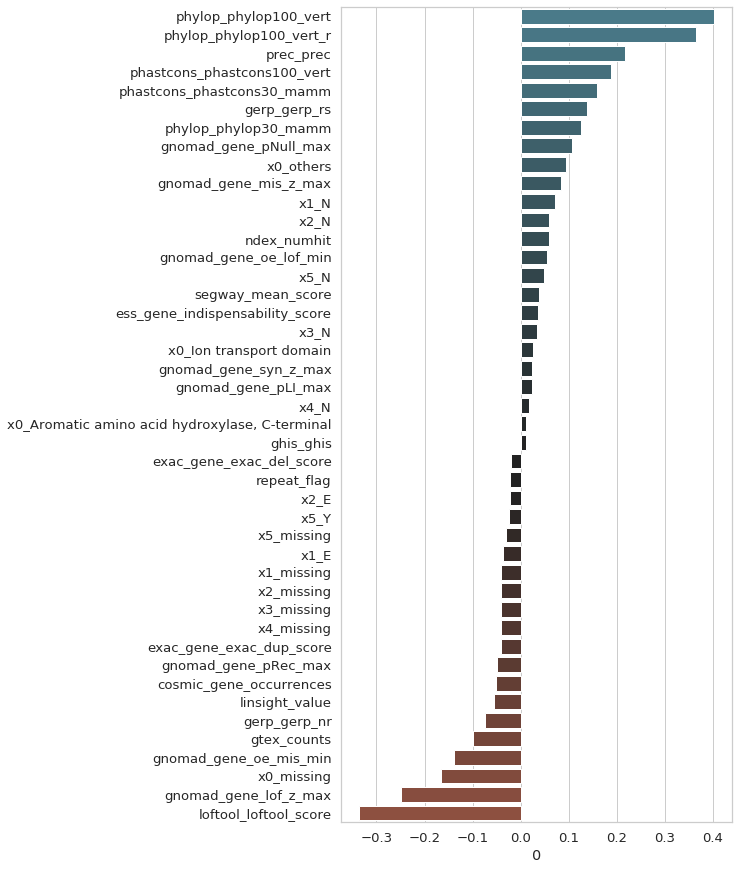

In [32]:
matplotlib.rcParams['figure.figsize'] = [7,15]
sns.set_style("whitegrid")
#coefs = pd.Series(model['0.01']['clasificador'].coef_[0])

#cols = numeric_names + categorical_output_names 
#coefs.index = cols
#coefs = coefs.sort_values(ascending=False)

# filtro los features que no fueron eliminados por L1
#ii = abs(coefs)>0
g = sns.barplot(res[0],res.index, palette =sns.diverging_palette(220, 20, n=50, center = "dark"))
#plt.xticks(rotation=90)
plt.show()

###  Raro que  Non Essenctial categories salgan con coeficientes positivos. 
* raro biogrid también

## RFE con L1 o L2. Qué concluye?